In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel_BatchNorm'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel_BatchNorm(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel_BatchNorm().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 5313


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.001),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=200,
    patience=200,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:01<00:00, 499.20it/s]


Epoch   1/200: RMSE_train: 1,734,310, RMSE_val: 1,738,842


100%|██████████| 646/646 [00:01<00:00, 459.32it/s]


Epoch   2/200: RMSE_train: 1,734,326, RMSE_val: 1,732,986


100%|██████████| 646/646 [00:01<00:00, 498.94it/s]


Epoch   3/200: RMSE_train: 1,734,142, RMSE_val: 1,732,717


100%|██████████| 646/646 [00:01<00:00, 511.16it/s]


Epoch   4/200: RMSE_train: 1,733,963, RMSE_val: 1,740,302
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 509.35it/s]


Epoch   5/200: RMSE_train: 1,733,632, RMSE_val: 1,738,641
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 507.58it/s]


Epoch   6/200: RMSE_train: 1,733,521, RMSE_val: 1,726,177


100%|██████████| 646/646 [00:01<00:00, 510.91it/s]


Epoch   7/200: RMSE_train: 1,733,026, RMSE_val: 1,737,256
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 513.90it/s]


Epoch   8/200: RMSE_train: 1,732,654, RMSE_val: 1,735,135
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 494.24it/s]


Epoch   9/200: RMSE_train: 1,732,187, RMSE_val: 1,724,888


100%|██████████| 646/646 [00:01<00:00, 462.05it/s]


Epoch  10/200: RMSE_train: 1,731,795, RMSE_val: 1,727,200
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 509.45it/s]


Epoch  11/200: RMSE_train: 1,731,124, RMSE_val: 1,727,369
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 519.25it/s]


Epoch  12/200: RMSE_train: 1,730,496, RMSE_val: 1,727,629
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 518.81it/s]


Epoch  13/200: RMSE_train: 1,729,964, RMSE_val: 1,720,945


100%|██████████| 646/646 [00:01<00:00, 507.59it/s]


Epoch  14/200: RMSE_train: 1,729,261, RMSE_val: 1,723,921
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 493.74it/s]


Epoch  15/200: RMSE_train: 1,728,584, RMSE_val: 1,728,099
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 493.40it/s]


Epoch  16/200: RMSE_train: 1,727,865, RMSE_val: 1,726,638
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 494.36it/s]


Epoch  17/200: RMSE_train: 1,727,085, RMSE_val: 1,723,745
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 512.76it/s]


Epoch  18/200: RMSE_train: 1,726,374, RMSE_val: 1,719,230


100%|██████████| 646/646 [00:01<00:00, 507.29it/s]


Epoch  19/200: RMSE_train: 1,725,388, RMSE_val: 1,725,160
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 488.40it/s]


Epoch  20/200: RMSE_train: 1,724,751, RMSE_val: 1,719,548
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 503.06it/s]


Epoch  21/200: RMSE_train: 1,723,797, RMSE_val: 1,725,903
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 505.29it/s]


Epoch  22/200: RMSE_train: 1,722,908, RMSE_val: 1,722,474
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 517.95it/s]


Epoch  23/200: RMSE_train: 1,721,758, RMSE_val: 1,718,715


100%|██████████| 646/646 [00:01<00:00, 516.58it/s]


Epoch  24/200: RMSE_train: 1,720,717, RMSE_val: 1,720,726
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 507.49it/s]


Epoch  25/200: RMSE_train: 1,719,856, RMSE_val: 1,723,077
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 507.28it/s]


Epoch  26/200: RMSE_train: 1,718,692, RMSE_val: 1,729,469
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 511.19it/s]


Epoch  27/200: RMSE_train: 1,717,461, RMSE_val: 1,711,975


100%|██████████| 646/646 [00:01<00:00, 517.92it/s]


Epoch  28/200: RMSE_train: 1,716,357, RMSE_val: 1,718,057
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 511.22it/s]


Epoch  29/200: RMSE_train: 1,715,188, RMSE_val: 1,720,795
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 488.59it/s]


Epoch  30/200: RMSE_train: 1,714,152, RMSE_val: 1,713,023
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 523.36it/s]


Epoch  31/200: RMSE_train: 1,712,658, RMSE_val: 1,722,323
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 505.69it/s]


Epoch  32/200: RMSE_train: 1,711,356, RMSE_val: 1,711,031


100%|██████████| 646/646 [00:01<00:00, 517.47it/s]


Epoch  33/200: RMSE_train: 1,710,106, RMSE_val: 1,716,408
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 506.45it/s]


Epoch  34/200: RMSE_train: 1,708,637, RMSE_val: 1,715,848
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 517.26it/s]


Epoch  35/200: RMSE_train: 1,707,243, RMSE_val: 1,705,282


100%|██████████| 646/646 [00:01<00:00, 523.47it/s]


Epoch  36/200: RMSE_train: 1,705,757, RMSE_val: 1,705,985
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 517.33it/s]


Epoch  37/200: RMSE_train: 1,704,259, RMSE_val: 1,706,608
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 527.90it/s]


Epoch  38/200: RMSE_train: 1,702,978, RMSE_val: 1,705,793
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 523.03it/s]


Epoch  39/200: RMSE_train: 1,701,321, RMSE_val: 1,704,292


100%|██████████| 646/646 [00:01<00:00, 508.42it/s]


Epoch  40/200: RMSE_train: 1,699,694, RMSE_val: 1,702,788


100%|██████████| 646/646 [00:01<00:00, 515.24it/s]


Epoch  41/200: RMSE_train: 1,698,070, RMSE_val: 1,703,224
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 476.47it/s]


Epoch  42/200: RMSE_train: 1,696,458, RMSE_val: 1,700,109


100%|██████████| 646/646 [00:01<00:00, 494.87it/s]


Epoch  43/200: RMSE_train: 1,694,916, RMSE_val: 1,702,113
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 517.17it/s]


Epoch  44/200: RMSE_train: 1,693,270, RMSE_val: 1,702,753
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 514.88it/s]


Epoch  45/200: RMSE_train: 1,691,385, RMSE_val: 1,704,883
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 518.79it/s]


Epoch  46/200: RMSE_train: 1,689,475, RMSE_val: 1,695,349


100%|██████████| 646/646 [00:01<00:00, 523.77it/s]


Epoch  47/200: RMSE_train: 1,687,630, RMSE_val: 1,697,170
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 524.00it/s]


Epoch  48/200: RMSE_train: 1,685,909, RMSE_val: 1,697,643
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 511.17it/s]


Epoch  49/200: RMSE_train: 1,683,929, RMSE_val: 1,687,589


100%|██████████| 646/646 [00:01<00:00, 515.06it/s]


Epoch  50/200: RMSE_train: 1,681,840, RMSE_val: 1,694,751
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 520.24it/s]


Epoch  51/200: RMSE_train: 1,680,050, RMSE_val: 1,700,597
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 528.56it/s]


Epoch  52/200: RMSE_train: 1,677,868, RMSE_val: 1,699,249
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 498.92it/s]


Epoch  53/200: RMSE_train: 1,675,984, RMSE_val: 1,683,446


100%|██████████| 646/646 [00:01<00:00, 521.03it/s]


Epoch  54/200: RMSE_train: 1,673,656, RMSE_val: 1,688,889
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 524.42it/s]


Epoch  55/200: RMSE_train: 1,671,754, RMSE_val: 1,687,745
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 529.61it/s]


Epoch  56/200: RMSE_train: 1,669,675, RMSE_val: 1,681,469


100%|██████████| 646/646 [00:01<00:00, 521.60it/s]


Epoch  57/200: RMSE_train: 1,667,406, RMSE_val: 1,678,195


100%|██████████| 646/646 [00:01<00:00, 500.46it/s]


Epoch  58/200: RMSE_train: 1,665,118, RMSE_val: 1,680,622
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 498.81it/s]


Epoch  59/200: RMSE_train: 1,663,202, RMSE_val: 1,682,884
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 492.00it/s]


Epoch  60/200: RMSE_train: 1,660,599, RMSE_val: 1,684,957
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 481.38it/s]


Epoch  61/200: RMSE_train: 1,658,366, RMSE_val: 1,679,083
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 485.90it/s]


Epoch  62/200: RMSE_train: 1,655,880, RMSE_val: 1,677,637


100%|██████████| 646/646 [00:01<00:00, 495.73it/s]


Epoch  63/200: RMSE_train: 1,653,587, RMSE_val: 1,670,026


100%|██████████| 646/646 [00:01<00:00, 503.89it/s]


Epoch  64/200: RMSE_train: 1,651,334, RMSE_val: 1,671,412
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 477.82it/s]


Epoch  65/200: RMSE_train: 1,648,772, RMSE_val: 1,682,095
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 472.31it/s]


Epoch  66/200: RMSE_train: 1,646,190, RMSE_val: 1,665,914


100%|██████████| 646/646 [00:01<00:00, 460.31it/s]


Epoch  67/200: RMSE_train: 1,643,727, RMSE_val: 1,667,769
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 493.88it/s]


Epoch  68/200: RMSE_train: 1,641,205, RMSE_val: 1,663,422


100%|██████████| 646/646 [00:01<00:00, 510.58it/s]


Epoch  69/200: RMSE_train: 1,638,456, RMSE_val: 1,672,002
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 500.74it/s]


Epoch  70/200: RMSE_train: 1,636,103, RMSE_val: 1,672,408
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 501.52it/s]


Epoch  71/200: RMSE_train: 1,633,299, RMSE_val: 1,655,853


100%|██████████| 646/646 [00:01<00:00, 506.60it/s]


Epoch  72/200: RMSE_train: 1,630,609, RMSE_val: 1,661,347
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 502.21it/s]


Epoch  73/200: RMSE_train: 1,627,776, RMSE_val: 1,658,812
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 496.18it/s]


Epoch  74/200: RMSE_train: 1,625,007, RMSE_val: 1,648,711


100%|██████████| 646/646 [00:01<00:00, 506.91it/s]


Epoch  75/200: RMSE_train: 1,622,224, RMSE_val: 1,665,746
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 508.38it/s]


Epoch  76/200: RMSE_train: 1,619,385, RMSE_val: 1,652,349
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 510.97it/s]


Epoch  77/200: RMSE_train: 1,616,449, RMSE_val: 1,649,783
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 504.87it/s]


Epoch  78/200: RMSE_train: 1,613,584, RMSE_val: 1,645,991


100%|██████████| 646/646 [00:01<00:00, 506.74it/s]


Epoch  79/200: RMSE_train: 1,610,597, RMSE_val: 1,656,265
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 503.30it/s]


Epoch  80/200: RMSE_train: 1,607,716, RMSE_val: 1,649,058
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 504.69it/s]


Epoch  81/200: RMSE_train: 1,604,757, RMSE_val: 1,640,868


100%|██████████| 646/646 [00:01<00:00, 505.90it/s]


Epoch  82/200: RMSE_train: 1,601,569, RMSE_val: 1,630,980


100%|██████████| 646/646 [00:01<00:00, 483.91it/s]


Epoch  83/200: RMSE_train: 1,598,576, RMSE_val: 1,639,288
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 493.80it/s]


Epoch  84/200: RMSE_train: 1,595,345, RMSE_val: 1,637,640
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 469.44it/s]


Epoch  85/200: RMSE_train: 1,592,459, RMSE_val: 1,628,467


100%|██████████| 646/646 [00:01<00:00, 479.28it/s]


Epoch  86/200: RMSE_train: 1,589,244, RMSE_val: 1,634,481
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 458.27it/s]


Epoch  87/200: RMSE_train: 1,585,839, RMSE_val: 1,646,475
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 458.57it/s]


Epoch  88/200: RMSE_train: 1,582,554, RMSE_val: 1,642,441
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 457.52it/s]


Epoch  89/200: RMSE_train: 1,579,210, RMSE_val: 1,628,862
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 442.23it/s]


Epoch  90/200: RMSE_train: 1,576,614, RMSE_val: 1,620,984


100%|██████████| 646/646 [00:01<00:00, 472.25it/s]


Epoch  91/200: RMSE_train: 1,572,857, RMSE_val: 1,618,350


100%|██████████| 646/646 [00:01<00:00, 450.42it/s]


Epoch  92/200: RMSE_train: 1,569,239, RMSE_val: 1,614,426


100%|██████████| 646/646 [00:01<00:00, 487.22it/s]


Epoch  93/200: RMSE_train: 1,566,087, RMSE_val: 1,630,230
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 496.81it/s]


Epoch  94/200: RMSE_train: 1,562,502, RMSE_val: 1,620,293
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 498.04it/s]


Epoch  95/200: RMSE_train: 1,559,405, RMSE_val: 1,610,305


100%|██████████| 646/646 [00:01<00:00, 503.50it/s]


Epoch  96/200: RMSE_train: 1,555,660, RMSE_val: 1,607,227


100%|██████████| 646/646 [00:01<00:00, 500.78it/s]


Epoch  97/200: RMSE_train: 1,552,126, RMSE_val: 1,600,042


100%|██████████| 646/646 [00:01<00:00, 500.34it/s]


Epoch  98/200: RMSE_train: 1,548,730, RMSE_val: 1,602,679
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 500.85it/s]


Epoch  99/200: RMSE_train: 1,544,931, RMSE_val: 1,608,081
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 503.61it/s]


Epoch 100/200: RMSE_train: 1,541,324, RMSE_val: 1,589,979


100%|██████████| 646/646 [00:01<00:00, 482.34it/s]


Epoch 101/200: RMSE_train: 1,537,730, RMSE_val: 1,596,985
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 451.37it/s]


Epoch 102/200: RMSE_train: 1,534,062, RMSE_val: 1,600,864
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 483.27it/s]


Epoch 103/200: RMSE_train: 1,529,835, RMSE_val: 1,597,864
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 483.90it/s]


Epoch 104/200: RMSE_train: 1,526,451, RMSE_val: 1,581,320


100%|██████████| 646/646 [00:01<00:00, 447.00it/s]


Epoch 105/200: RMSE_train: 1,522,706, RMSE_val: 1,575,499


100%|██████████| 646/646 [00:01<00:00, 486.94it/s]


Epoch 106/200: RMSE_train: 1,518,572, RMSE_val: 1,572,519


100%|██████████| 646/646 [00:01<00:00, 473.37it/s]


Epoch 107/200: RMSE_train: 1,515,003, RMSE_val: 1,593,799
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 478.08it/s]


Epoch 108/200: RMSE_train: 1,511,149, RMSE_val: 1,595,515
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 482.28it/s]


Epoch 109/200: RMSE_train: 1,506,981, RMSE_val: 1,588,213
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 479.64it/s]


Epoch 110/200: RMSE_train: 1,503,101, RMSE_val: 1,595,205
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 414.95it/s]


Epoch 111/200: RMSE_train: 1,498,861, RMSE_val: 1,582,281
EarlyStopping counter: 5 out of 200


100%|██████████| 646/646 [00:01<00:00, 444.84it/s]


Epoch 112/200: RMSE_train: 1,495,241, RMSE_val: 1,570,060


100%|██████████| 646/646 [00:01<00:00, 471.48it/s]


Epoch 113/200: RMSE_train: 1,490,986, RMSE_val: 1,587,131
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 483.29it/s]


Epoch 114/200: RMSE_train: 1,486,803, RMSE_val: 1,550,054


100%|██████████| 646/646 [00:01<00:00, 453.01it/s]


Epoch 115/200: RMSE_train: 1,482,962, RMSE_val: 1,557,708
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 462.66it/s]


Epoch 116/200: RMSE_train: 1,478,385, RMSE_val: 1,594,884
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 484.77it/s]


Epoch 117/200: RMSE_train: 1,474,200, RMSE_val: 1,554,283
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 489.55it/s]


Epoch 118/200: RMSE_train: 1,470,471, RMSE_val: 1,557,503
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 456.00it/s]


Epoch 119/200: RMSE_train: 1,465,940, RMSE_val: 1,547,721


100%|██████████| 646/646 [00:01<00:00, 455.13it/s]


Epoch 120/200: RMSE_train: 1,461,745, RMSE_val: 1,560,277
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 483.94it/s]


Epoch 121/200: RMSE_train: 1,457,816, RMSE_val: 1,538,528


100%|██████████| 646/646 [00:01<00:00, 471.45it/s]


Epoch 122/200: RMSE_train: 1,453,325, RMSE_val: 1,536,691


100%|██████████| 646/646 [00:01<00:00, 448.43it/s]


Epoch 123/200: RMSE_train: 1,448,471, RMSE_val: 1,538,732
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 456.80it/s]


Epoch 124/200: RMSE_train: 1,443,661, RMSE_val: 1,537,728
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 491.73it/s]


Epoch 125/200: RMSE_train: 1,440,228, RMSE_val: 1,526,515


100%|██████████| 646/646 [00:01<00:00, 492.84it/s]


Epoch 126/200: RMSE_train: 1,434,703, RMSE_val: 1,512,342


100%|██████████| 646/646 [00:01<00:00, 481.85it/s]


Epoch 127/200: RMSE_train: 1,431,138, RMSE_val: 1,553,241
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 456.66it/s]


Epoch 128/200: RMSE_train: 1,427,163, RMSE_val: 1,542,577
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 433.39it/s]


Epoch 129/200: RMSE_train: 1,421,975, RMSE_val: 1,546,024
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 455.86it/s]


Epoch 130/200: RMSE_train: 1,416,870, RMSE_val: 1,537,543
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 486.32it/s]


Epoch 131/200: RMSE_train: 1,413,103, RMSE_val: 1,538,458
EarlyStopping counter: 5 out of 200


100%|██████████| 646/646 [00:01<00:00, 477.95it/s]


Epoch 132/200: RMSE_train: 1,407,744, RMSE_val: 1,528,094
EarlyStopping counter: 6 out of 200


100%|██████████| 646/646 [00:01<00:00, 479.32it/s]


Epoch 133/200: RMSE_train: 1,403,662, RMSE_val: 1,521,544
EarlyStopping counter: 7 out of 200


100%|██████████| 646/646 [00:01<00:00, 492.10it/s]


Epoch 134/200: RMSE_train: 1,398,949, RMSE_val: 1,534,315
EarlyStopping counter: 8 out of 200


100%|██████████| 646/646 [00:01<00:00, 478.55it/s]


Epoch 135/200: RMSE_train: 1,394,414, RMSE_val: 1,527,853
EarlyStopping counter: 9 out of 200


100%|██████████| 646/646 [00:01<00:00, 491.68it/s]


Epoch 136/200: RMSE_train: 1,388,866, RMSE_val: 1,558,291
EarlyStopping counter: 10 out of 200


100%|██████████| 646/646 [00:01<00:00, 501.30it/s]


Epoch 137/200: RMSE_train: 1,383,750, RMSE_val: 1,633,810
EarlyStopping counter: 11 out of 200


100%|██████████| 646/646 [00:01<00:00, 486.27it/s]


Epoch 138/200: RMSE_train: 1,379,753, RMSE_val: 1,516,693
EarlyStopping counter: 12 out of 200


100%|██████████| 646/646 [00:01<00:00, 497.80it/s]


Epoch 139/200: RMSE_train: 1,375,352, RMSE_val: 1,488,013


100%|██████████| 646/646 [00:01<00:00, 506.92it/s]


Epoch 140/200: RMSE_train: 1,369,564, RMSE_val: 1,488,182
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 510.13it/s]


Epoch 141/200: RMSE_train: 1,366,264, RMSE_val: 1,476,905


100%|██████████| 646/646 [00:01<00:00, 502.20it/s]


Epoch 142/200: RMSE_train: 1,360,424, RMSE_val: 1,471,768


100%|██████████| 646/646 [00:01<00:00, 511.78it/s]


Epoch 143/200: RMSE_train: 1,354,948, RMSE_val: 1,481,760
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 495.97it/s]


Epoch 144/200: RMSE_train: 1,350,220, RMSE_val: 1,474,114
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 472.48it/s]


Epoch 145/200: RMSE_train: 1,345,082, RMSE_val: 1,475,981
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 507.79it/s]


Epoch 146/200: RMSE_train: 1,339,802, RMSE_val: 1,474,565
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 510.67it/s]


Epoch 147/200: RMSE_train: 1,334,490, RMSE_val: 1,459,867


100%|██████████| 646/646 [00:01<00:00, 508.78it/s]


Epoch 148/200: RMSE_train: 1,330,002, RMSE_val: 1,540,505
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 475.40it/s]


Epoch 149/200: RMSE_train: 1,324,700, RMSE_val: 1,540,044
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 502.76it/s]


Epoch 150/200: RMSE_train: 1,319,800, RMSE_val: 1,459,485


100%|██████████| 646/646 [00:01<00:00, 493.43it/s]


Epoch 151/200: RMSE_train: 1,314,932, RMSE_val: 1,478,151
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 482.34it/s]


Epoch 152/200: RMSE_train: 1,309,537, RMSE_val: 1,446,775


100%|██████████| 646/646 [00:01<00:00, 474.05it/s]


Epoch 153/200: RMSE_train: 1,303,378, RMSE_val: 1,472,133
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 471.95it/s]


Epoch 154/200: RMSE_train: 1,299,141, RMSE_val: 1,449,422
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 486.84it/s]


Epoch 155/200: RMSE_train: 1,293,530, RMSE_val: 1,464,006
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 456.57it/s]


Epoch 156/200: RMSE_train: 1,288,692, RMSE_val: 1,464,752
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 475.07it/s]


Epoch 157/200: RMSE_train: 1,282,951, RMSE_val: 1,437,465


100%|██████████| 646/646 [00:01<00:00, 476.02it/s]


Epoch 158/200: RMSE_train: 1,278,712, RMSE_val: 1,418,216


100%|██████████| 646/646 [00:01<00:00, 479.50it/s]


Epoch 159/200: RMSE_train: 1,271,171, RMSE_val: 1,428,832
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 481.18it/s]


Epoch 160/200: RMSE_train: 1,265,784, RMSE_val: 1,416,346


100%|██████████| 646/646 [00:01<00:00, 490.67it/s]


Epoch 161/200: RMSE_train: 1,260,282, RMSE_val: 1,417,521
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 475.53it/s]


Epoch 162/200: RMSE_train: 1,254,941, RMSE_val: 1,410,149


100%|██████████| 646/646 [00:01<00:00, 471.24it/s]


Epoch 163/200: RMSE_train: 1,249,518, RMSE_val: 1,425,991
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 480.97it/s]


Epoch 164/200: RMSE_train: 1,244,537, RMSE_val: 1,413,822
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 475.85it/s]


Epoch 165/200: RMSE_train: 1,239,260, RMSE_val: 1,407,610


100%|██████████| 646/646 [00:01<00:00, 445.20it/s]


Epoch 166/200: RMSE_train: 1,233,059, RMSE_val: 1,444,151
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 485.26it/s]


Epoch 167/200: RMSE_train: 1,227,343, RMSE_val: 1,443,160
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 487.33it/s]


Epoch 168/200: RMSE_train: 1,223,213, RMSE_val: 1,458,501
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 486.70it/s]


Epoch 169/200: RMSE_train: 1,217,609, RMSE_val: 1,443,540
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 485.92it/s]


Epoch 170/200: RMSE_train: 1,212,124, RMSE_val: 1,388,215


100%|██████████| 646/646 [00:01<00:00, 483.76it/s]


Epoch 171/200: RMSE_train: 1,206,708, RMSE_val: 1,361,817


100%|██████████| 646/646 [00:01<00:00, 476.00it/s]


Epoch 172/200: RMSE_train: 1,199,704, RMSE_val: 1,367,213
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 485.17it/s]


Epoch 173/200: RMSE_train: 1,195,015, RMSE_val: 1,367,921
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 479.53it/s]


Epoch 174/200: RMSE_train: 1,187,695, RMSE_val: 1,385,498
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 486.59it/s]


Epoch 175/200: RMSE_train: 1,182,410, RMSE_val: 1,369,618
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 478.49it/s]


Epoch 176/200: RMSE_train: 1,176,553, RMSE_val: 1,360,776


100%|██████████| 646/646 [00:01<00:00, 442.95it/s]


Epoch 177/200: RMSE_train: 1,170,437, RMSE_val: 1,441,227
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 479.90it/s]


Epoch 178/200: RMSE_train: 1,165,761, RMSE_val: 1,374,520
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 459.25it/s]


Epoch 179/200: RMSE_train: 1,159,264, RMSE_val: 1,380,628
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 449.08it/s]


Epoch 180/200: RMSE_train: 1,152,152, RMSE_val: 1,346,549


100%|██████████| 646/646 [00:01<00:00, 450.14it/s]


Epoch 181/200: RMSE_train: 1,146,639, RMSE_val: 1,337,229


100%|██████████| 646/646 [00:01<00:00, 453.98it/s]


Epoch 182/200: RMSE_train: 1,142,701, RMSE_val: 1,362,947
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 458.35it/s]


Epoch 183/200: RMSE_train: 1,137,539, RMSE_val: 1,329,938


100%|██████████| 646/646 [00:01<00:00, 445.59it/s]


Epoch 184/200: RMSE_train: 1,130,127, RMSE_val: 1,349,177
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 463.83it/s]


Epoch 185/200: RMSE_train: 1,124,644, RMSE_val: 1,326,937


100%|██████████| 646/646 [00:01<00:00, 475.98it/s]


Epoch 186/200: RMSE_train: 1,117,261, RMSE_val: 1,347,148
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 469.69it/s]


Epoch 187/200: RMSE_train: 1,112,419, RMSE_val: 1,308,664


100%|██████████| 646/646 [00:01<00:00, 474.89it/s]


Epoch 188/200: RMSE_train: 1,105,884, RMSE_val: 1,444,184
EarlyStopping counter: 1 out of 200


100%|██████████| 646/646 [00:01<00:00, 478.87it/s]


Epoch 189/200: RMSE_train: 1,099,324, RMSE_val: 1,328,665
EarlyStopping counter: 2 out of 200


100%|██████████| 646/646 [00:01<00:00, 432.96it/s]


Epoch 190/200: RMSE_train: 1,094,592, RMSE_val: 2,412,379
EarlyStopping counter: 3 out of 200


100%|██████████| 646/646 [00:01<00:00, 494.11it/s]


Epoch 191/200: RMSE_train: 1,085,970, RMSE_val: 2,969,023
EarlyStopping counter: 4 out of 200


100%|██████████| 646/646 [00:01<00:00, 457.94it/s]


Epoch 192/200: RMSE_train: 1,082,193, RMSE_val: 1,393,903
EarlyStopping counter: 5 out of 200


100%|██████████| 646/646 [00:01<00:00, 488.47it/s]


Epoch 193/200: RMSE_train: 1,076,605, RMSE_val: 2,717,056
EarlyStopping counter: 6 out of 200


100%|██████████| 646/646 [00:01<00:00, 503.60it/s]


Epoch 194/200: RMSE_train: 1,068,991, RMSE_val: 2,450,066
EarlyStopping counter: 7 out of 200


100%|██████████| 646/646 [00:01<00:00, 506.85it/s]


Epoch 195/200: RMSE_train: 1,062,855, RMSE_val: 2,583,382
EarlyStopping counter: 8 out of 200


100%|██████████| 646/646 [00:01<00:00, 503.29it/s]


Epoch 196/200: RMSE_train: 1,056,938, RMSE_val: 1,561,501
EarlyStopping counter: 9 out of 200


100%|██████████| 646/646 [00:01<00:00, 509.12it/s]


Epoch 197/200: RMSE_train: 1,050,553, RMSE_val: 1,365,581
EarlyStopping counter: 10 out of 200


100%|██████████| 646/646 [00:01<00:00, 456.63it/s]


Epoch 198/200: RMSE_train: 1,046,947, RMSE_val: 1,584,106
EarlyStopping counter: 11 out of 200


100%|██████████| 646/646 [00:01<00:00, 505.44it/s]


Epoch 199/200: RMSE_train: 1,038,747, RMSE_val: 1,609,404
EarlyStopping counter: 12 out of 200


100%|██████████| 646/646 [00:01<00:00, 496.04it/s]

Epoch 200/200: RMSE_train: 1,032,421, RMSE_val: 2,082,539
EarlyStopping counter: 13 out of 200


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset         RMSE         MAE   MAPE      R2
----------------------------------------------
train   1086106.574  693558.811  0.532   0.243
val     1310490.197  739135.989  0.559  -0.121
test    1307677.094  735042.808  0.544  -0.105
----------------------------------------------
total   1157356.606  706412.725  0.537   0.138


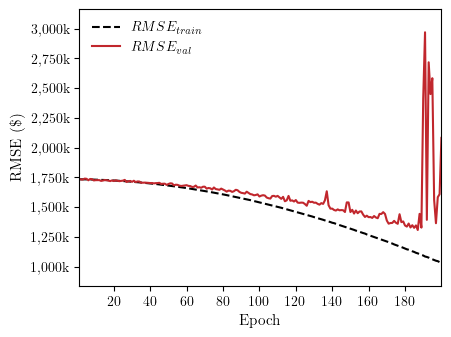

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

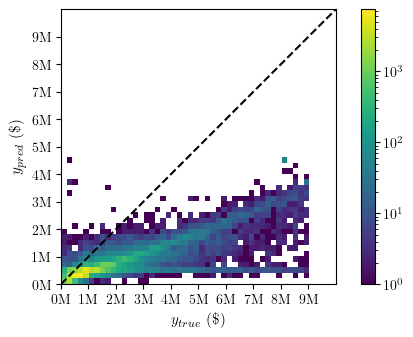

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')